# Проведение АА-тестов

По данным с '2022-01-24' по '2023-01-30', нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом. Сделать выводы об одинаковости выборок, корректоности работы системы сплитования

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns
import hashlib
import pandahouse as ph
import random

### 2. Выгрузка данных по условию

In [2]:
# функция для выполнения запосов
def select(q):
    return ph.read_clickhouse(q, connection=connection)

In [3]:
# устанавливаем параметры
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': '*****',
    'database': '*****'
}

In [4]:
# Выгрузка данных по условию: '2022-01-24' по '2023-01-30' и 2 и 3 экспериментальной группы
query = '''SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

In [5]:
df_group = select(query)  # сохраняем данныe по условию: '2022-01-24' по '2023-01-30' и 2 и 3 экспериментальной группы

In [6]:
df_group

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


### 3. Проверка гипотез

Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [7]:
alpha = .05 # критический уровень статистической значимости

In [9]:
# Создадим вспомогательную функцию
def simulation (df1, df2, n_users, n_tests):
    p_value = []
    for i in range(n_tests):
        sample_1 = df1.sample(n_users, replace=False)
        sample_2 = df2.sample(n_users, replace=False)
        t_test = st.ttest_ind(sample_1, sample_2, equal_var=False)
        p_value.append(t_test[1])
    return p_value

In [10]:
p_value = simulation(df_group[df_group.exp_group == 2].ctr, df_group[df_group.exp_group == 3].ctr, 500, 10000)

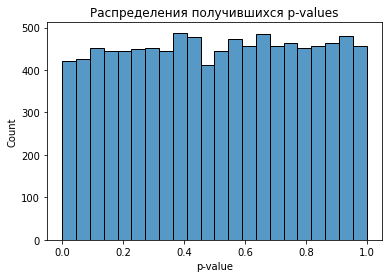

In [11]:
sns.histplot(p_value)
plt.title('Распределения получившихся p-values')
plt.xlabel('p-value')
plt.show()

In [12]:
print('Среднее значение p-value:', sum(p_value) / len(p_value))

Среднее значение p-value: 0.5057931261265185


In [13]:
print('Процент p-values меньше либо равен 0.05:', len([item for item in p_value if item <= 0.05]) / len(p_value) * 100, '%')

Процент p-values меньше либо равен 0.05: 4.63 %


### Вывод

Рассматривая распределение получившихся p-values и учитывая, что процент тестов, которые показывают изменения, т.е. отвергается нулевая гипотеза о равенстве,  меньше  чем в 5% случаях от всего количество проведенных тестов.
Согласно проведенному анализу, можно прийти к выводу, что выборки одинаковые, т.е. наша система сплитования корректно работает